In [1]:
%load_ext autoreload
%autoreload 2

# Split (combined) dataset into Train and Validation
---

In [2]:
def distribute_samples(data_splits, total_nb_samples):
    # Calculate the base number of samples for each split
    base_samples_per_split = total_nb_samples // len(data_splits)
    # Calculate the remainder
    remainder = total_nb_samples % len(data_splits)

    samples_to_take = []
    
    # Distribute the samples
    for i in range(len(data_splits)):
        if i < remainder:
            samples_to_take.append(base_samples_per_split + 1)
        else:
            samples_to_take.append(base_samples_per_split)

    return samples_to_take

In [3]:
def split_combined_dataset(combined_dataset, k_splits, num_train_samples, num_val_samples, seq_len, tau, reverse, use_residual, smooth_data):

    # Choose whether to use calcium or residual data
    if use_residual:
        key_data = "residual_calcium"
    else:
        key_data = "calcium_data"

    # Choose whether to use original or smoothed data
    if smooth_data:
        key_data = "smooth_" + key_data
    else:
        key_data = key_data

    # Store the training and validation datasets
    train_dataset = []
    val_dataset = []

    # Loop through the worms in the dataset
    for wormID, single_worm_dataset in combined_dataset.items():

        # Extract relevant features from the dataset
        data = single_worm_dataset[key_data]
        neurons_mask = single_worm_dataset["named_neurons_mask"]
        time_vec = single_worm_dataset["time_in_seconds"]

        # Verifications
        assert isinstance(seq_len, int) and 0 < seq_len < len(data), "seq_len must be an integer > 0 and < len(data)"
        assert isinstance(tau, int) and tau < (len(data) - seq_len), "The desired tau is too long. Try a smaller value"
        assert seq_len < (len(data) // k_splits), "The desired seq_len is too long. Try a smaller seq_len or decreasing k_splits"

        # Split the data and the time vector into k splits
        data_splits = np.array_split(data, k_splits)
        time_vec_splits = np.array_split(time_vec, k_splits)

        # Separate the splits into training and validation sets
        train_data_splits = data_splits[::2]
        train_time_vec_splits = time_vec_splits[::2]
        val_data_splits = data_splits[1::2]
        val_time_vec_splits = time_vec_splits[1::2]

        # Number of total time steps in each split
        total_train_time_steps = np.sum([len(split) for split in train_data_splits])
        total_val_time_steps = np.sum([len(split) for split in val_data_splits])

        # Number of samples in each split
        train_samples_per_split = distribute_samples(train_data_splits, num_train_samples)
        val_samples_per_split = distribute_samples(val_data_splits, num_val_samples)

        # Create a dataset for each split
        for train_split, train_time_split, num_samples_split in zip(train_data_splits, train_time_vec_splits, train_samples_per_split):
            train_dataset.append(
                NeuralActivityDataset(
                    data = train_split.detach(),
                    time_vec = train_time_split.detach(),
                    neurons_mask = neurons_mask,
                    seq_len = seq_len,
                    num_samples = num_samples_split,
                    tau = tau,
                    use_residual = use_residual,
                    reverse = reverse,
                )
            )

        
        for val_split, val_time_split, num_samples_split in zip(val_data_splits, val_time_vec_splits, val_samples_per_split):
            val_dataset.append(
                NeuralActivityDataset(
                    data = val_split.detach(),
                    time_vec = val_time_split.detach(),
                    neurons_mask = neurons_mask,
                    seq_len = seq_len,
                    num_samples = num_samples_split,
                    tau = tau,
                    use_residual = use_residual,
                    reverse = reverse,
                )
            )

    # Concatenate the datasets
    train_dataset = torch.utils.data.ConcatDataset(train_dataset) # Nb of train examples = nb train samples * nb of worms
    val_dataset = torch.utils.data.ConcatDataset(val_dataset) # Nb of val examples = nb train samples * nb of worms

    # Save the datasets
    torch.save(train_dataset, "train_dataset.pth")
    torch.save(val_dataset, "val_dataset.pth")

    return train_dataset, val_dataset

In [61]:
dataset_config = OmegaConf.load("../../../configs/submodule/dataset_new.yaml")
print(OmegaConf.to_yaml(dataset_config.dataset.for_training))

experimental_datasets:
- Kato2015
- Nichols2017
num_named_neurons: 2
num_worms: 10
k_splits: 2
num_train_samples: 16
num_val_samples: 4
seq_len: 120
tau: 1
reverse: false
use_residual: false
smooth_data: true



In [62]:
def get_datasets(dataset_config: DictConfig, name='train'):

    experimental_datasets = dataset_config.experimental_datasets
    num_named_neurons = dataset_config.num_named_neurons
    num_worms = dataset_config.num_worms
    k_splits = dataset_config.k_splits
    num_train_samples = dataset_config.num_train_samples
    num_val_samples = dataset_config.num_val_samples
    seq_len = dataset_config.seq_len
    tau = dataset_config.tau
    reverse = dataset_config.reverse
    use_residual = dataset_config.use_residual
    smooth_data = dataset_config.smooth_data

    # Verifications
    assert isinstance(k_splits, int) and k_splits > 1, "k_splits must be an integer > 1"

    assert isinstance(num_named_neurons, int) or num_named_neurons == "all", (
        "num_named_neurons must be a positive integer or 'all'."
    )

    assert isinstance(num_worms, int) or num_worms == "all", (
        "num_worms must be a positive integer or 'all'."
    )

    combined_dataset = create_combined_dataset(experimental_datasets, num_named_neurons, num_worms, name=name)
    train_dataset, val_dataset = split_combined_dataset(combined_dataset, k_splits, num_train_samples,
                                                         num_val_samples, seq_len, tau, reverse,
                                                         use_residual, smooth_data)

    return train_dataset, val_dataset

In [63]:
train_dataset, val_dataset = get_datasets(dataset_config.dataset.for_training, name='train')

In [64]:
x1,y1,m1,m = next(iter(train_dataset))

In [65]:
(x1[1:,:] == y1[:-1,:]).all()

tensor(True)

In [59]:
len(val_dataset)

40

In [17]:
train_dataset, val_dataset = split_combined_dataset(
    combined_dataset = combined_dataset,
    k_splits = 2,
    num_train_samples = 16,
    num_val_samples = 8,
    seq_len = 100,
    tau = 1,
    reverse = False,
    use_residual = False,
    smooth_data = True,
)

In [19]:
# Create the dataloaders

trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle = True,
)

In [21]:
for x, y, mask, _ in trainloader:
    print(x.shape, y.shape, mask.shape)

torch.Size([16, 100, 302]) torch.Size([16, 100, 302]) torch.Size([16, 302])
torch.Size([16, 100, 302]) torch.Size([16, 100, 302]) torch.Size([16, 302])
torch.Size([16, 100, 302]) torch.Size([16, 100, 302]) torch.Size([16, 302])
torch.Size([16, 100, 302]) torch.Size([16, 100, 302]) torch.Size([16, 302])
torch.Size([16, 100, 302]) torch.Size([16, 100, 302]) torch.Size([16, 302])
torch.Size([16, 100, 302]) torch.Size([16, 100, 302]) torch.Size([16, 302])
torch.Size([16, 100, 302]) torch.Size([16, 100, 302]) torch.Size([16, 302])
torch.Size([16, 100, 302]) torch.Size([16, 100, 302]) torch.Size([16, 302])
torch.Size([16, 100, 302]) torch.Size([16, 100, 302]) torch.Size([16, 302])
torch.Size([16, 100, 302]) torch.Size([16, 100, 302]) torch.Size([16, 302])


# Train Loop
---

In [4]:
from data._main import get_datasets
from models._main import get_model
from omegaconf import OmegaConf
import torch
import mlflow

In [5]:
dataset_config = OmegaConf.load("../../../configs/submodule/dataset.yaml")
dataset_config = dataset_config.dataset.for_training
print(OmegaConf.to_yaml(dataset_config))

experimental_datasets:
- Kato2015
- Nichols2017
num_named_neurons: 2
num_worms: 10
k_splits: 2
num_train_samples: 16
num_val_samples: 4
seq_len: 120
tau: 1
reverse: false
use_residual: false
smooth_data: true



In [6]:
model_config = OmegaConf.load("../../../configs/submodule/model.yaml").model
print(OmegaConf.to_yaml(model_config))

type: NetworkLSTM
input_size: 302
hidden_size: 256
num_layers: 1
loss: MSE
fft_reg_param: 0.0
l1_reg_param: 0.0
checkpoint_path: null



In [7]:
def compute_loss(loss_fn, X, Y, masks):
    """
    Compute loss for each sample in the batch and average them.
    
    This is necessary because inside each minibatch, different examples can have different masks.
    Therefore, different examples will have different shapes, and the loss function will not be able to
    compute the loss for the entire batch at once.

    Parameters
    ----------
    loss_fn : torch.nn.Module
        A loss function instance.
    X : torch.Tensor
        A batch of input sequences. Shape: (batch_size, seq_len, input_size).
    Y : torch.Tensor
        A batch of target sequences. Shape: (batch_size, seq_len, input_size).
    masks : torch.Tensor
        A batch of masks. Shape: (batch_size, seq_len).
    """
    
    # Calculate loss
    losses = []
    for i in range(X.shape[0]):
        valid_X = X[i][:, masks[i]]
        valid_Y = Y[i][:, masks[i]]
        loss_i = loss_fn(valid_X, valid_Y)
        losses.append(loss_i)

    # Compute average loss for backpropagation
    total_loss = torch.mean(torch.stack(losses))

    return total_loss

In [10]:
train_dataset, val_dataset = get_datasets(dataset_config=dataset_config, name='training')

1

In [8]:
epochs = 10
batch_size = 4
shuffle = True
tau = 1 #! ARGUMENT

train_dataset, val_dataset = get_datasets(dataset_config=dataset_config, name='training')
model = get_model(model_config=model_config)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
criterion = model.loss_fn()

# Create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

running_base_loss_train = 0
running_loss_train = 0
train_epoch_loss = []
train_epoch_baseline = []

running_base_loss_val = 0
running_loss_val = 0
val_epoch_loss = []
val_epoch_baseline = []

for epoch in range(epochs):

    # Train loop
    model.train()

    for batch_idx, (X_train, Y_train, masks_train, metadata) in enumerate(trainloader):

        optimizer.zero_grad() # Reset gradients

        # Baseline model: identity model - predict that the next time step is the same as the current one.
        # This is the simplest model we can think of: predict that the next time step is the same as the current one
        # is better than predict any other random number.
        train_baseline = compute_loss(loss_fn=criterion, X=X_train, Y=Y_train, masks=masks_train)
        
        # Model
        y_pred = model(X_train, masks_train, tau)
        train_loss = compute_loss(loss_fn=criterion, X=y_pred, Y=Y_train, masks=masks_train)

        # Backpropagation (skip first epoch)
        train_loss.backward()
        optimizer.step()

        # Update running losses
        running_base_loss_train += train_baseline.item()
        running_loss_train += train_loss.item()

    train_epoch_loss.append(running_loss_train / len(trainloader))
    train_epoch_baseline.append(running_base_loss_train / len(trainloader))
    running_base_loss_train = 0
    running_loss_train = 0

    # Validation loop
    model.eval()

    with torch.no_grad():
        for batch_idx, (X_val, Y_val, masks_val, metadata_val) in enumerate(valloader):

            # Baseline model: identity model - predict that the next time step is the same as the current one.
            # This is the simplest model we can think of: predict that the next time step is the same as the current one
            # is better than predict any other random number.
            val_baseline = compute_loss(loss_fn=criterion, X=X_val, Y=Y_val, masks=masks_val)

            # Model
            y_pred = model(X_val, masks_val, tau)
            val_loss = compute_loss(loss_fn=criterion, X=y_pred, Y=Y_val, masks=masks_val)

            # Update running losses
            running_base_loss_val += val_baseline.item()
            running_loss_val += val_loss.item()

        val_epoch_loss.append(running_loss_val / len(valloader))
        val_epoch_baseline.append(running_base_loss_val / len(valloader))
        running_base_loss_val = 0
        running_loss_val = 0

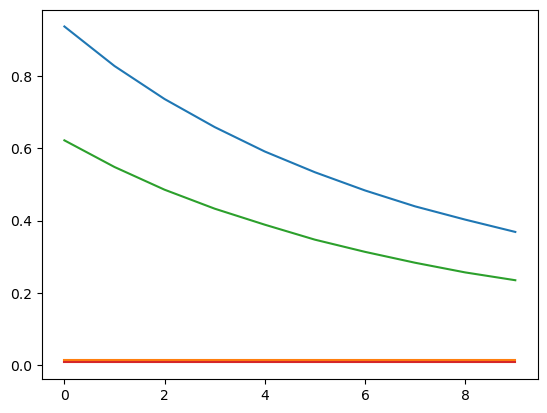

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_loss)
plt.plot(train_epoch_baseline)
plt.plot(val_epoch_loss)
plt.plot(val_epoch_baseline)